# Mini Project, Analyzing Temperature Data in Texas

In [262]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from datetime import datetime 
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
# %matplotlib inline 
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.impute import SimpleImputer

We will upload data for the temperature in various locations throughout the world over the past two hundred years.

In [263]:
df = pd.read_csv(r'/Users/malachihale/codeup-data-science/time-series-exercises/GlobalLandTemperaturesByState.csv')

In [264]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


For the purpose of this project, we will select only the data in the state of Texas.

In [265]:
df = df[df.State == "Texas"]

In [266]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [267]:
df.tail()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
552047,2013-05-01,22.628,0.158,Texas,United States
552048,2013-06-01,27.841,0.220,Texas,United States
552049,2013-07-01,27.630,0.182,Texas,United States
552050,2013-08-01,28.663,0.247,Texas,United States
552051,2013-09-01,26.408,1.112,Texas,United States


For the sake of data integrity, we will check that all of our Texas data is also in the United States. 

In [268]:
df[df.Country != "United States"]

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country


All of our data points are located in the United States.

We will prepare the data by converting our date column to datetime

In [269]:
def prep_data(df):
    # Reassign the sale_date column to be a datetime type
    df['date'] = pd.to_datetime(df.dt)
    
    # Sort rows by the date and then set the index as that date
    df = df.set_index("date").sort_index()
    
    df = df.drop(columns = ["dt"])

    return df

In [270]:
df = prep_data(df)

In [271]:
df.head(3)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
date,,,,
1820-01-01,4.489,3.369,Texas,United States
1820-02-01,9.081,2.873,Texas,United States
1820-03-01,12.657,2.423,Texas,United States


In [272]:
df.tail(3)

,AverageTemperature,AverageTemperatureUncertainty,State,Country
date,,,,
2013-07-01,27.630,0.182,Texas,United States
2013-08-01,28.663,0.247,Texas,United States
2013-09-01,26.408,1.112,Texas,United States


We will now keep on the `date` and `AverageTemperature` column.

In [273]:
df = df.groupby(['date'])[['AverageTemperature']].sum()

In [274]:
df.head(3)

,AverageTemperature
date,
1820-01-01,4.489
1820-02-01,9.081
1820-03-01,12.657


To finish preparing the data, we will take care of any null values by replacing them with the average of the `AverageTemperature` column

In [275]:
imputer = SimpleImputer(strategy='mean')

for col in df.columns:
    df[[col]] = imputer.fit_transform(df[[col]])
    

In [276]:
df.head(3)

,AverageTemperature
date,
1820-01-01,4.489
1820-02-01,9.081
1820-03-01,12.657


## Split Data

We will split the data into train, validate, and test datasets.

In [277]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

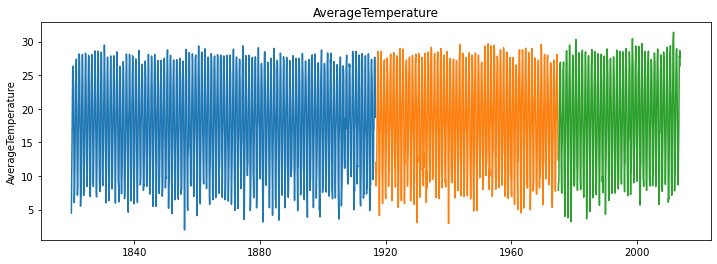

In [278]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Exploratory Graphs

In [280]:
y = train.AverageTemperature

<AxesSubplot:ylabel='Frequency'>

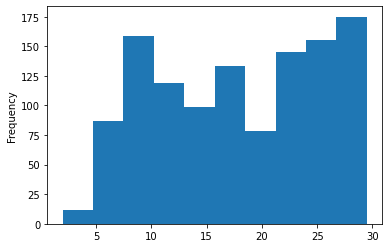

In [281]:
y.plot.hist()

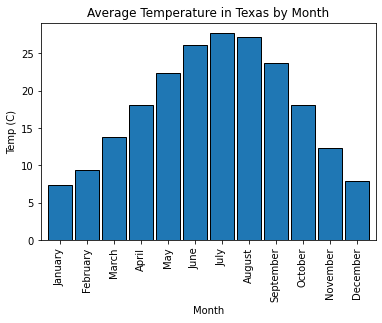

In [301]:
ax = y.groupby(y.index.strftime('%m-%B')).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
title = ax.set(title='Average Temperature in Texas by Month', xlabel='Month', ylabel='Temp (C)')
labels = ax.get_xticklabels()
set_labels = ax.set_xticklabels([l.get_text()[3:] for l in labels])

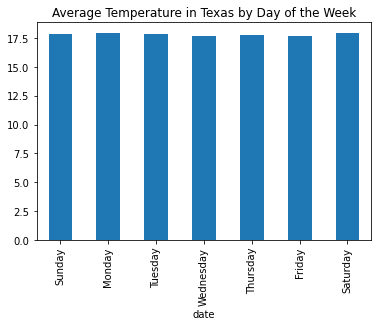

In [303]:
ax = y.groupby(y.index.strftime('%w-%A')).mean().plot.bar()
title = ax.set(title = "Average Temperature in Texas by Day of the Week")
labels = ax.get_xticklabels()
set_labels = ax.set_xticklabels([l.get_text()[2:] for l in labels])

[Text(0.5, 1.0, 'Average Temperatures in Texas over Time')]

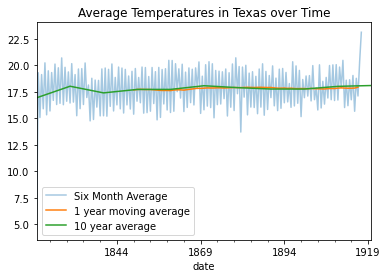

In [307]:
ax = y.resample('6M').mean().plot(label='Six Month Average', alpha=.4)
y.resample('Y').mean().rolling(30).mean().plot(ax=ax, label='1 year moving average')
y.resample('10Y').mean().plot(ax=ax, label='10 year average')
ax.legend()
ax.set(title = "Average Temperatures in Texas over Time")

## Evalutive Functions

In [120]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [121]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [122]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [123]:
eval_df

,model_type,target_var,rmse


## Forecast

### Simple Average

In [124]:
AverageTemperature = train['AverageTemperature'].mean()

def make_predictions():
    yhat_df = pd.DataFrame({'AverageTemperature': [AverageTemperature]}
                           , index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [125]:
yhat_df.head()

,AverageTemperature
date,
1916-11-01,17.829652
1916-12-01,17.829652
1917-01-01,17.829652
1917-02-01,17.829652
1917-03-01,17.829652


AverageTemperature -- RMSE: 7


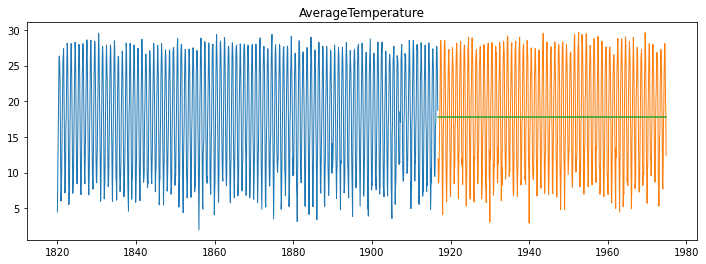

In [126]:
for col in train.columns:
    plot_and_eval(col)

In [127]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [128]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0


### Moving Average

In [129]:
period = 3

AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]

yhat_df = make_predictions()
yhat_df.head(3)

,AverageTemperature
date,
1916-11-01,23.658
1916-12-01,23.658
1917-01-01,23.658


AverageTemperature -- RMSE: 9


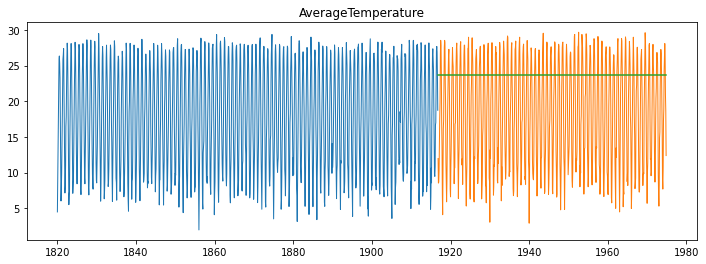

In [130]:
for col in train.columns:
    plot_and_eval(col)

In [131]:
for col in train.columns:
    eval_df = append_eval_df(model_type='3 month moving average', 
                             target_var = col)

In [132]:
periods = [1, 4, 8, 12, 24]

for p in periods:
    AverageTemperature = train['AverageTemperature'].rolling(period).median().iloc[-1]

    yhat_df = make_predictions()
    model_type = str(p) + ' month moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'AverageTemperature')

In [133]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,3 month moving average,AverageTemperature,9.0
2,1 month moving average,AverageTemperature,9.0
3,4 month moving average,AverageTemperature,9.0
4,8 month moving average,AverageTemperature,9.0
5,12 month moving average,AverageTemperature,9.0
6,24 month moving average,AverageTemperature,9.0


### Holt's Linear Trend

AverageTemperature 



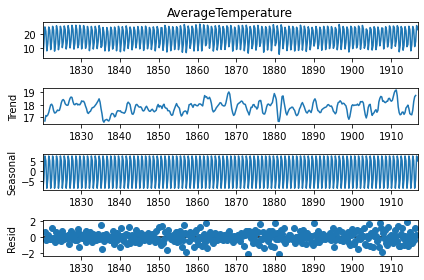

In [134]:
import statsmodels.api as sm

for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('3M').mean()).plot()
    plt.show()

In [135]:
for col in train.columns:
    model = Holt(train[col], exponential = False)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = False)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

AverageTemperature -- RMSE: 102


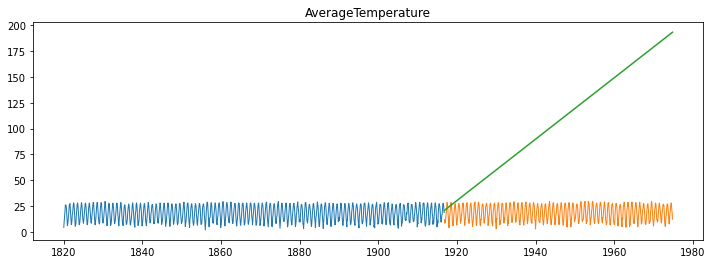

In [136]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [137]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [138]:
eval_df

,model_type,target_var,rmse
0,simple_average,AverageTemperature,7.0
1,3 month moving average,AverageTemperature,9.0
2,1 month moving average,AverageTemperature,9.0
3,4 month moving average,AverageTemperature,9.0
4,8 month moving average,AverageTemperature,9.0
5,12 month moving average,AverageTemperature,9.0
6,24 month moving average,AverageTemperature,9.0
7,Holts,AverageTemperature,102.0


### Previous Model

In [246]:
train = df[:'1955']
validate = df['1956':'1985']
test = df['1986':'2013']

In [247]:
len(validate)

360

In [248]:
len(test)

333

In [210]:
train.head()

,AverageTemperature
date,
1820-01-01,4.489
1820-02-01,9.081
1820-03-01,12.657
1820-04-01,19.215
1820-05-01,22.577


In [211]:
len(validate)

360

In [212]:
train[: '1955']

,AverageTemperature
date,
1820-01-01,4.489
1820-02-01,9.081
1820-03-01,12.657
1820-04-01,19.215
1820-05-01,22.577
...,...
1955-08-01,27.545
1955-09-01,25.374
1955-10-01,19.189


In [213]:
train['1995' :]

,AverageTemperature
date,


In [221]:
yhat_df = train['1926':'1955'] - train.diff(30*12).mean()

In [222]:
yhat_df

,AverageTemperature
date,
1926-01-01,5.683789
1926-02-01,12.007789
1926-03-01,11.760789
1926-04-01,15.536789
1926-05-01,21.329789
...,...
1955-08-01,27.343789
1955-09-01,25.172789
1955-10-01,18.987789


In [223]:
yhat_df = yhat_df.set_index(validate.index)

In [224]:
len(yhat_df)

360

In [225]:
yhat_df

,AverageTemperature
date,
1956-01-01,5.683789
1956-02-01,12.007789
1956-03-01,11.760789
1956-04-01,15.536789
1956-05-01,21.329789
...,...
1985-08-01,27.343789
1985-09-01,25.172789
1985-10-01,18.987789


AverageTemperature -- RMSE: 2


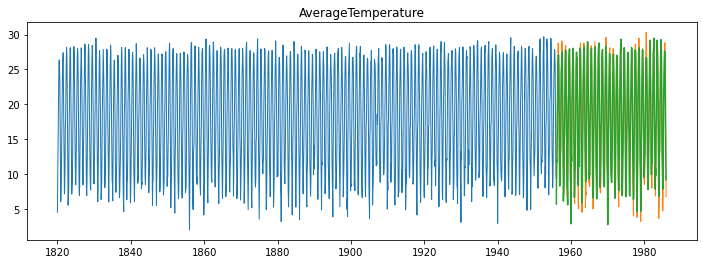

In [226]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)

## Conclusion

In [229]:
min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]
# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse) 
        )]

,model_type,target_var,rmse
8,previous year,AverageTemperature,2.0
9,previous year,AverageTemperature,2.0


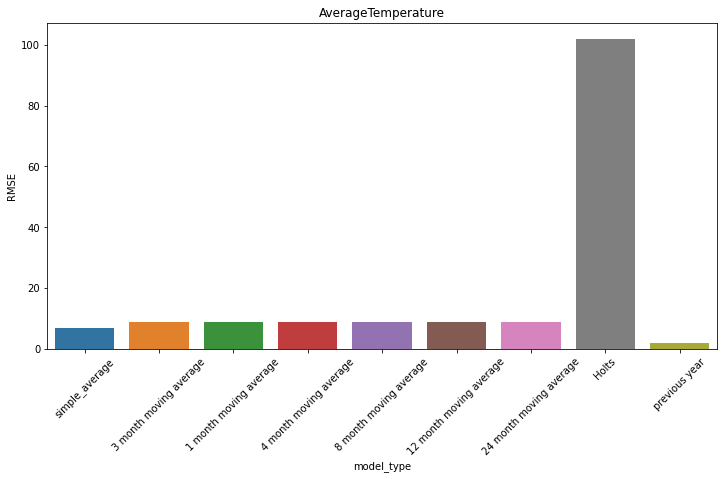

In [230]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

The Holt's model is by far the worst, so we will drop it. 

In [235]:
eval_df = eval_df.drop([7])

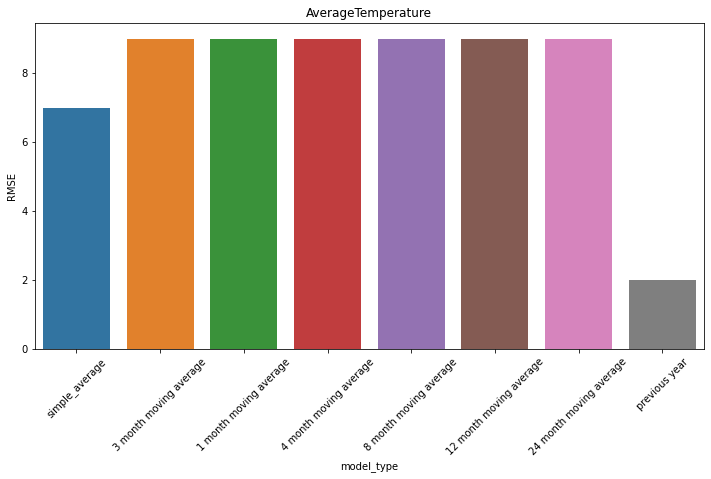

In [236]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x, y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.show()

Since our previous year model is our best model, we will run that model on our test dataset.

In [237]:
len(test)

333

In [254]:
validate['1958':'1985-09']

,AverageTemperature
date,
1958-01-01,6.972
1958-02-01,7.851
1958-03-01,10.186
1958-04-01,17.097
1958-05-01,22.620
...,...
1985-05-01,23.410
1985-06-01,26.000
1985-07-01,27.537


In [255]:
yhat_df = validate['1958':'1985-09'] + train.diff(333).mean()
yhat_df.index = test.index

In [257]:
yhat_df.head()

,AverageTemperature
date,
1986-01-01,7.159789
1986-02-01,8.038789
1986-03-01,10.373789
1986-04-01,17.284789
1986-05-01,22.807789


In [259]:
rmse = round(sqrt(mean_squared_error(test['AverageTemperature'], yhat_df['AverageTemperature'])), 0)
rmse

2.0

In [260]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(test[target_var], label = 'Test', linewidth = 1)
    plt.plot(yhat_df[target_var], alpha = .5)
    plt.title(target_var)
    plt.show()

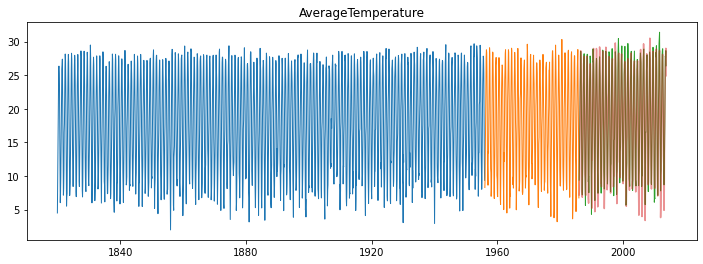

In [261]:
for col in train.columns:
    plot_and_eval(col)